In [1]:
import time
import numpy as np
import pandas as pd
import os

import cv2
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

In [2]:
data_dir = "D:/Lung_200"
img_height, img_width = 224, 224

In [18]:
# Update for 3 classes
class_labels = ["Lung_aca", "Lung_n", "Lung_scc"]

In [25]:
# Count images per class
image_counts = {label: len(os.listdir(os.path.join(data_dir, label))) for label in class_labels}
for folder, count in image_counts.items():
    print(f'Number of images in {folder}: {count}')

total_images = sum(image_counts.values())
print(f'Total number of images: {total_images}')

Number of images in Lung_aca: 200
Number of images in Lung_n: 200
Number of images in Lung_scc: 200
Total number of images: 600


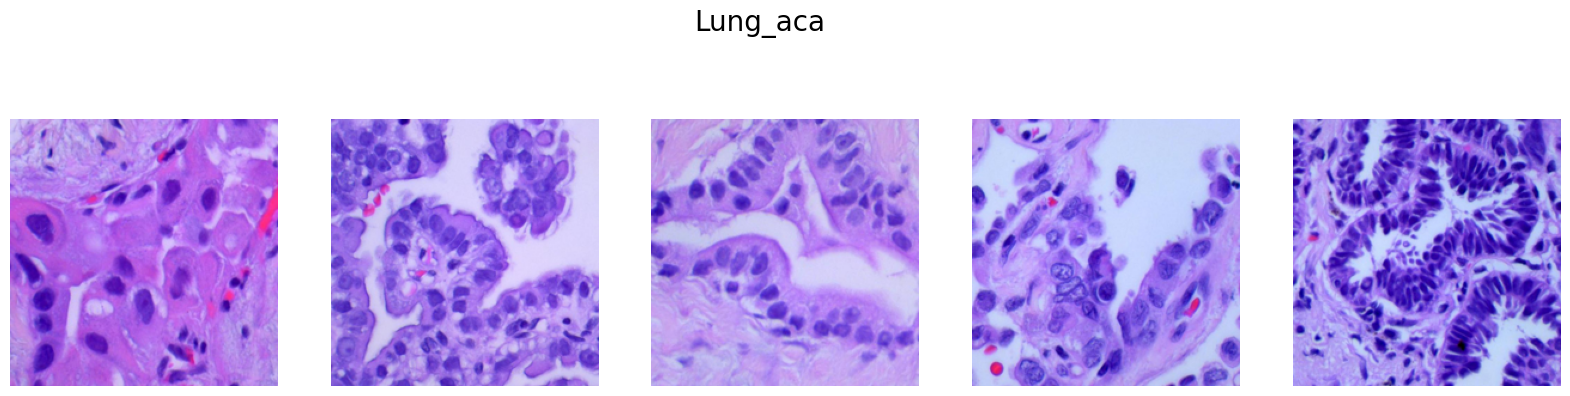

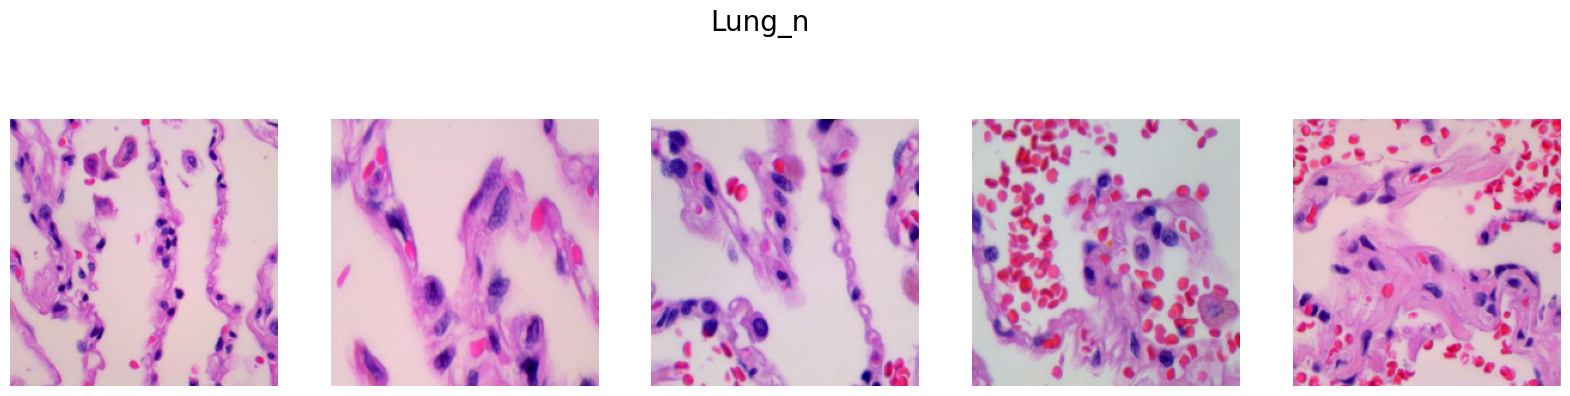

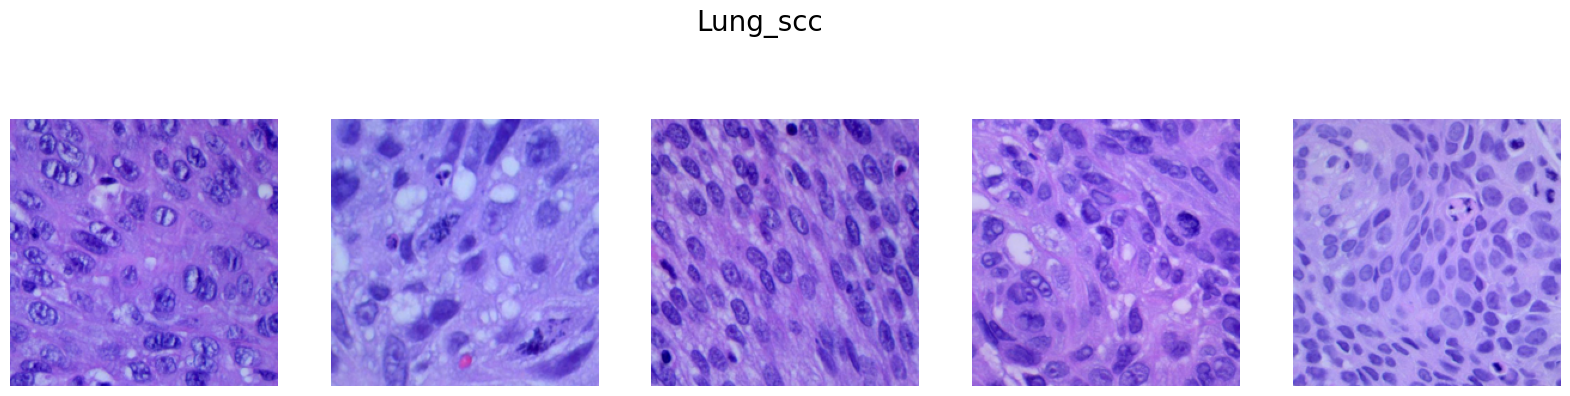

In [26]:
def display_images_from_folder(folder_name, images):
    fig, axes = plt.subplots(1, 5, figsize=(20, 5))
    fig.suptitle(folder_name, fontsize=20)
    for img, ax in zip(images, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.show()

for folder_name in class_labels:
    folder_path = os.path.join(data_dir, folder_name)
    image_files = os.listdir(folder_path)[:5]  
    
    images = []
    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        img = Image.open(image_path)
        img = img.resize((img_width, img_height))
        images.append(img)
    
    display_images_from_folder(folder_name, images)


In [27]:
data = []
labels = []
for label in class_labels:
    label_dir = os.path.join(data_dir, label)
    label_num = class_labels.index(label)
    for img_file in os.listdir(label_dir):
        img_path = os.path.join(label_dir, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (img_height, img_width))
            data.append(img)
            labels.append(label_num)

data = np.array(data) / 255.0
labels = np.array(labels)

In [29]:
print(f'Dimensions of images before entering VGG19: {data.shape}')

Dimensions of images before entering VGG19: (600, 224, 224, 3)


In [30]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(data, labels, stratify=labels, test_size=0.2, random_state=42)

In [31]:
# Load DenseNet121 model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
for layer in base_model.layers:
    layer.trainable = False

In [32]:
# Encoder Model
encoder = Sequential([
    base_model,
    GlobalAveragePooling2D()
])

In [33]:
# Measure time for feature extraction
start_time = time.time()
X_train_features = encoder.predict(X_train)
X_test_features = encoder.predict(X_test)
end_time = time.time()

print(f"Time taken for DenseNet121 feature extraction: {end_time - start_time:.2f} seconds")
print(f'Total number of features extracted using DenseNet121: {X_train_features.shape[1]}')
print(f'Dimensions of extracted features before flattening: {base_model.output.shape}')

15/15 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step
Time taken for DenseNet121 feature extraction: 38.44 seconds
Total number of features extracted using DenseNet121: 1024
Dimensions of extracted features before flattening: (None, 7, 7, 1024)


In [36]:
# Decoder Model
decoder = Sequential([
    Dense(1024, activation='relu', input_shape=(X_train_features.shape[1],)),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
])

# Measure time for decoding
start_time = time.time()
X_train_decoded = decoder.predict(X_train_features)
X_test_decoded = decoder.predict(X_test_features)
end_time = time.time()

print(f"Time taken for feature decoding: {end_time - start_time:.2f} seconds")
print(f'Total number of features after decoding: {X_train_decoded.shape[1]}')
print(f'Dimensions of decoded features: {X_train_decoded.shape}')

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Time taken for feature decoding: 0.28 seconds
Total number of features after decoding: 256
Dimensions of decoded features: (480, 256)


In [37]:
# Standardize features
scaler = StandardScaler()
start_time = time.time()
X_train_scaled = scaler.fit_transform(X_train_decoded)
X_test_scaled = scaler.transform(X_test_decoded)
end_time = time.time()

print(f"Time taken for feature scaling: {end_time - start_time:.2f} seconds")

Time taken for feature scaling: 0.02 seconds


In [38]:
# Apply PCA
pca = PCA(n_components=50)
start_time = time.time()
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
end_time = time.time()

print(f"Time taken for PCA transformation: {end_time - start_time:.2f} seconds")
print(f'Total number of features after PCA: {X_train_pca.shape[1]}')
print(f'Dimensions of PCA-transformed features: {X_train_pca.shape}')

Time taken for PCA transformation: 0.17 seconds
Total number of features after PCA: 50
Dimensions of PCA-transformed features: (480, 50)


In [39]:
from sklearn.svm import SVC

In [40]:
svm_classifier = SVC(random_state=42, probability=True)
svm_classifier.fit(X_train_pca, y_train)

SVC(probability=True, random_state=42)

In [41]:
y_pred_svc = svm_classifier.predict(X_test_pca)

Support Vector Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94        40
           1       1.00      1.00      1.00        40
           2       0.95      0.93      0.94        40

    accuracy                           0.96       120
   macro avg       0.96      0.96      0.96       120
weighted avg       0.96      0.96      0.96       120

Support Vector Confusion Matrix:
[[38  0  2]
 [ 0 40  0]
 [ 3  0 37]]


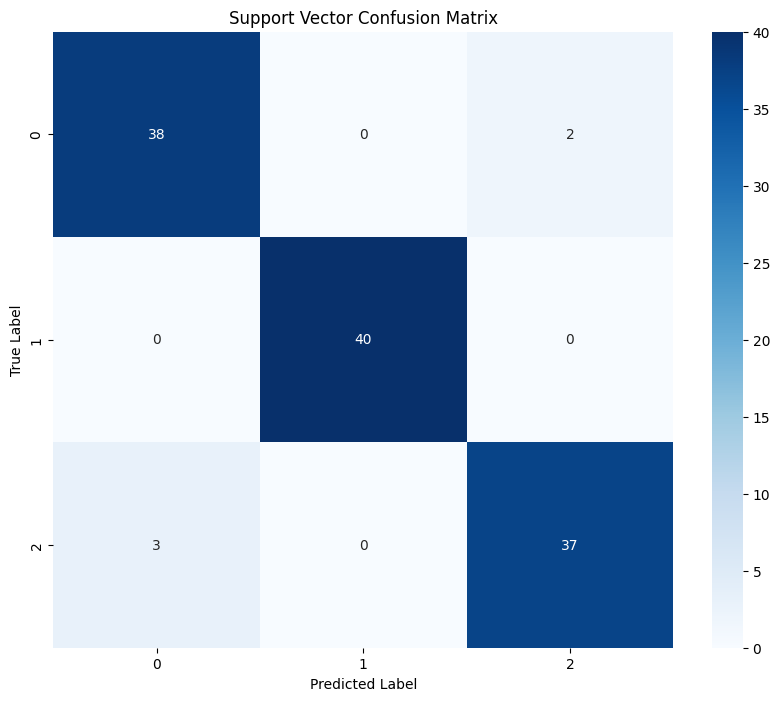

In [42]:
print("Support Vector Classification Report:")
print(classification_report(y_test, y_pred_svc))

print("Support Vector Confusion Matrix:")
conf_matrix_svc = confusion_matrix(y_test, y_pred_svc)
print(conf_matrix_svc)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_svc, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Support Vector Confusion Matrix')
plt.show()

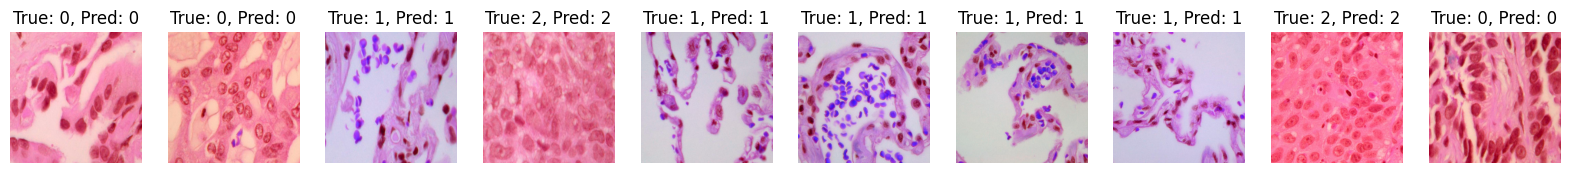

In [44]:
num_samples = 10
fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))

for i in range(num_samples):
    ax = axes[i]
    ax.imshow(X_test[i])
    ax.axis('off')
    ax.set_title(f"True: {y_test[i]}, Pred: {y_pred_svc[i]}")

plt.show()

In [45]:
param_grid = {
    'C': [0.1, 1, 10, 100],           
    'gamma': [1, 0.1, 0.01, 0.001],   
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']  
}

In [46]:
from sklearn.model_selection import GridSearchCV

svm = SVC(random_state=42, probability=True)

grid_search_svm = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)

grid_search_svm.fit(X_train_pca, y_train)

best_params = grid_search_svm.best_params_
best_estimator = grid_search_svm.best_estimator_

Fitting 5 folds for each of 64 candidates, totalling 320 fits


In [47]:
print("Best parameters found: ", best_params)
print("Best estimator found: ", best_estimator)

Best parameters found:  {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
Best estimator found:  SVC(C=1, gamma=0.001, probability=True, random_state=42)


In [48]:
best_model = grid_search_svm.best_estimator_

y_pred_svc = best_model.predict(X_test_pca)

Support Vector Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94        40
           1       1.00      1.00      1.00        40
           2       0.95      0.93      0.94        40

    accuracy                           0.96       120
   macro avg       0.96      0.96      0.96       120
weighted avg       0.96      0.96      0.96       120

Support Vector Confusion Matrix:
[[38  0  2]
 [ 0 40  0]
 [ 3  0 37]]


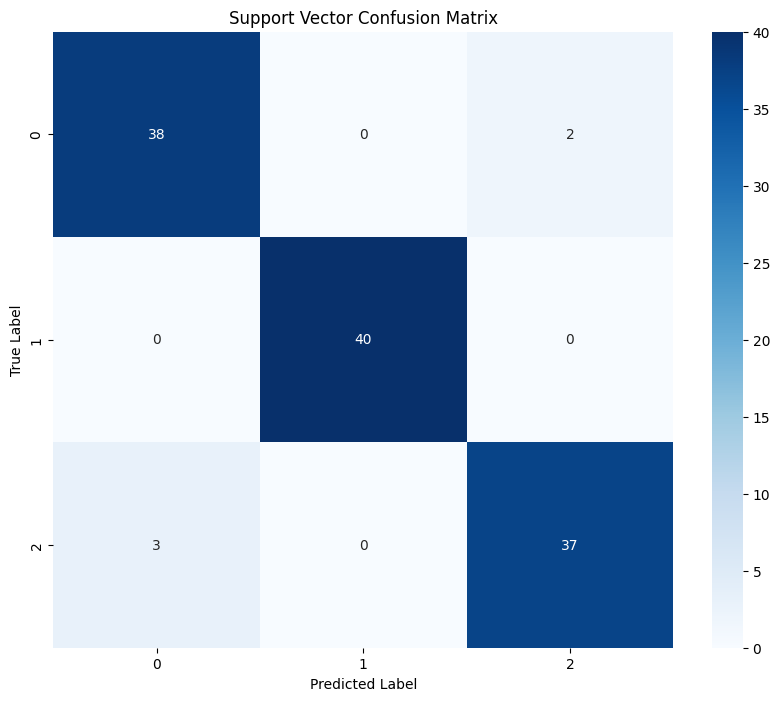

In [49]:

print("Support Vector Classification Report:")
print(classification_report(y_test, y_pred_svc))

print("Support Vector Confusion Matrix:")
conf_matrix_svc = confusion_matrix(y_test, y_pred_svc)
print(conf_matrix_svc)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_svc, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Support Vector Confusion Matrix')
plt.show()

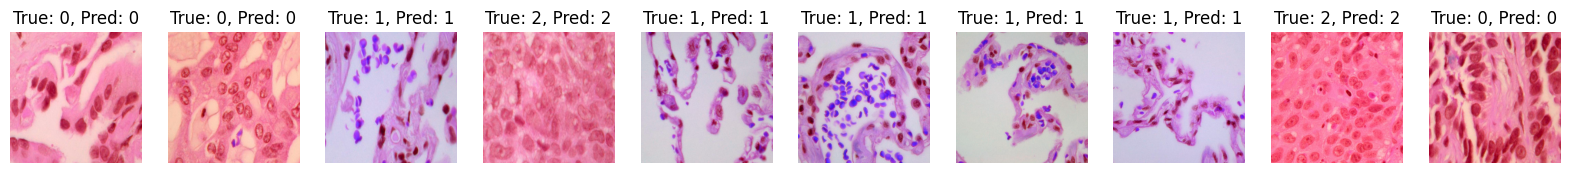

In [50]:
num_samples = 10
fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))

for i in range(num_samples):
    ax = axes[i]
    ax.imshow(X_test[i])
    ax.axis('off')
    ax.set_title(f"True: {y_test[i]}, Pred: {y_pred_svc[i]}")

plt.show()

In [51]:
# 10-fold cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(best_model, X_train_pca, y_train, cv=cv, scoring='accuracy')

print(f"Cross-Validation Scores: {cross_val_scores}")
print(f"Mean Cross-Validation Score: {cross_val_scores.mean()}")

Cross-Validation Scores: [0.95833333 0.95833333 0.97916667 0.95833333 0.95833333 0.9375
 0.9375     0.95833333 0.91666667 0.97916667]
Mean Cross-Validation Score: 0.9541666666666666


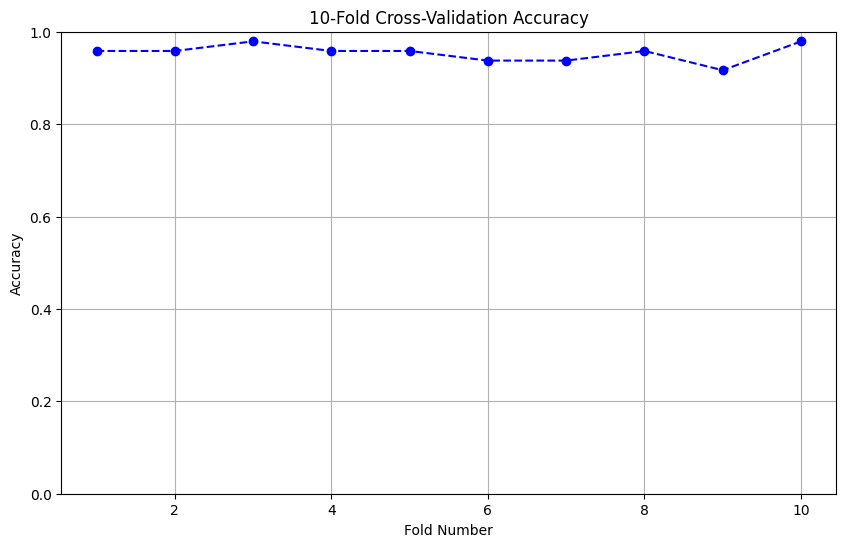

In [52]:
# Plot 10-fold cross-validation scores
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), cross_val_scores, marker='o', linestyle='--', color='b')
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.title('10-Fold Cross-Validation Accuracy')
plt.ylim(0.0, 1.0)  # Adjust the y-axis limits based on your accuracy range
plt.grid()
plt.show()

In [53]:
y_pred_proba = best_model.predict_proba(X_test_pca)

Unique classes in y_test: [0 1 2]
Shape of y_test_bin: (120, 3)
Shape of y_pred_proba: (120, 3)


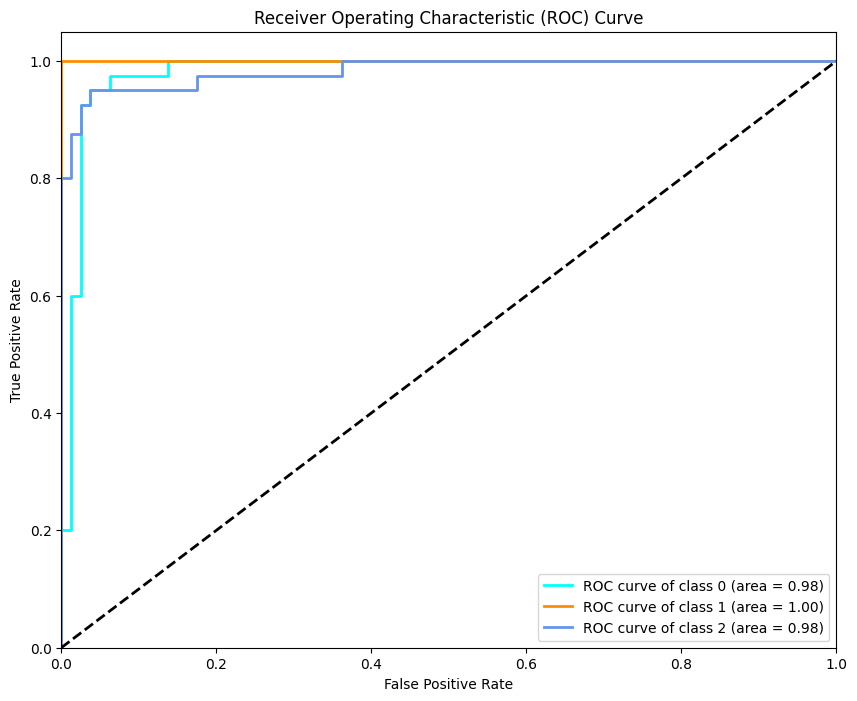

In [55]:
from sklearn.preprocessing import label_binarize

unique_classes = np.unique(y_test
                           )
# Check the unique classes in y_test
print(f"Unique classes in y_test: {np.unique(y_test)}")

# Binarize the output labels for ROC curve calculation
y_test_bin = label_binarize(y_test, classes=unique_classes)

# Check the shape of y_test_bin to confirm it has the correct number of classes
print(f"Shape of y_test_bin: {y_test_bin.shape}")
print(f"Shape of y_pred_proba: {y_pred_proba.shape}")

# Calculate ROC curves and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(unique_classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for all classes
plt.figure(figsize=(10, 8))
colors = ['aqua', 'darkorange', 'cornflowerblue']

for i, color in zip(range(len(unique_classes)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Deep Learning Algorithm - 1

In [56]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [58]:
# Define the neural network model with dropout layers
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_pca.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(6, activation='softmax')
])

In [59]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [60]:
# Convert labels to categorical
y_train_1 = to_categorical(y_train, num_classes=6)
y_test_1 = to_categorical(y_test, num_classes=6)

In [62]:
# Print the number of features at each stage
print(f"Number of features after DenseNet-121 extraction: {X_train_features.shape[1]}")
print(f"Number of features after decoding: {X_train_decoded.shape[1]}")
print(f"Number of features after PCA: {X_train_pca.shape[1]}")

Number of features after DenseNet-121 extraction: 1024
Number of features after decoding: 256
Number of features after PCA: 50


In [63]:
# Train the model
history = model.fit(X_train_pca, y_train_1, validation_data=(X_test_pca, y_test_1), epochs=10, batch_size=32)

Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.3767 - loss: 1.6656 - val_accuracy: 0.8917 - val_loss: 0.6318
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7079 - loss: 0.7076 - val_accuracy: 0.9250 - val_loss: 0.2922
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8453 - loss: 0.4697 - val_accuracy: 0.9500 - val_loss: 0.1838
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9061 - loss: 0.2972 - val_accuracy: 0.9500 - val_loss: 0.1617
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9145 - loss: 0.2266 - val_accuracy: 0.9500 - val_loss: 0.1527
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9383 - loss: 0.1766 - val_accuracy: 0.9500 - val_loss: 0.1481
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9258 - loss: 0.1906 - val_accuracy: 0.9667 - val_loss: 0.1447
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9503 - loss: 0.1712 - val_accuracy: 0.9500 - val_loss

In [64]:
# Make predictions
y_pred_prob = model.predict(X_test_pca)
y_pred = y_pred_prob.argmax(axis=-1)
y_test_labels = y_test_1.argmax(axis=-1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [65]:
print("Sample predictions:", y_pred[:10])
print("Sample true labels:", y_test_labels[:10])

Sample predictions: [0 0 1 2 1 1 1 1 2 0]
Sample true labels: [0 0 1 2 1 1 1 1 2 0]


In [66]:
# Plot training and validation accuracy and loss
epochs = range(1, len(history.history['accuracy']) + 1)

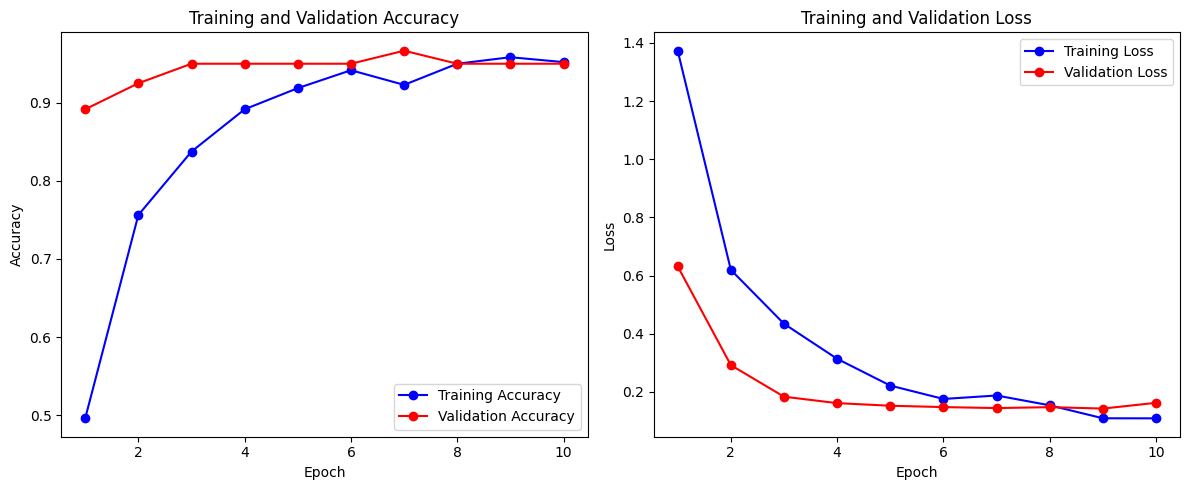

In [67]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], 'bo-', label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], 'bo-', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

Confusion Matrix:
[[38  0  2]
 [ 0 40  0]
 [ 4  0 36]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.95      0.93        40
           1       1.00      1.00      1.00        40
           2       0.95      0.90      0.92        40

    accuracy                           0.95       120
   macro avg       0.95      0.95      0.95       120
weighted avg       0.95      0.95      0.95       120



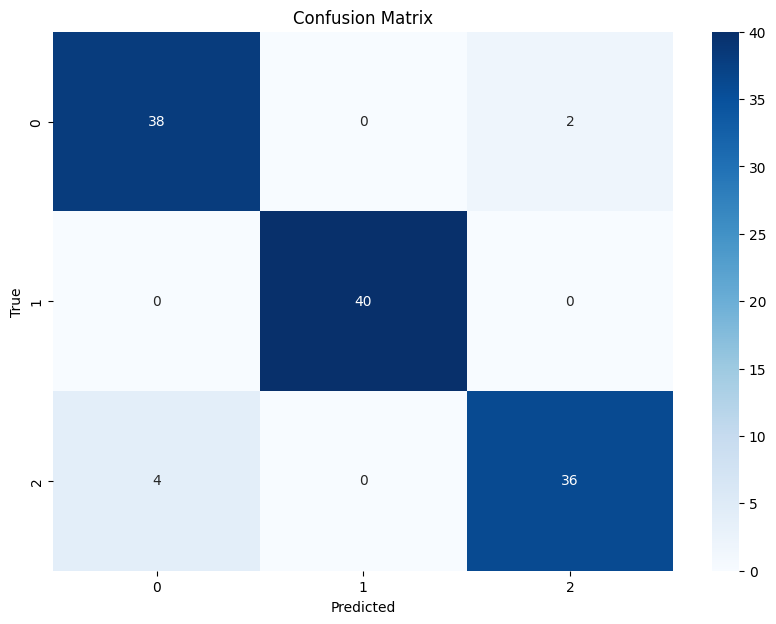

In [69]:
conf_matrix = confusion_matrix(y_test_labels, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

class_report = classification_report(y_test_labels, y_pred)
print("Classification Report:")
print(class_report)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(3), yticklabels=range(3))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [70]:
# 10-fold cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [71]:
def cross_val_keras_model(model, X, y, cv):
    val_scores = []
    for train_idx, val_idx in cv.split(X, y):
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]

        model_fold = Sequential([
            Dense(256, activation='relu', input_shape=(X.shape[1],)),
            Dropout(0.3),
            Dense(128, activation='relu'),
            Dropout(0.3),
            Dense(64, activation='relu'),
            Dropout(0.3),
            Dense(6, activation='softmax')
        ])

        model_fold.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        y_train_fold_cat = to_categorical(y_train_fold, num_classes=6)
        y_val_fold_cat = to_categorical(y_val_fold, num_classes=6)

        model_fold.fit(X_train_fold, y_train_fold_cat, epochs=10, batch_size=32, verbose=0)
        val_loss, val_accuracy = model_fold.evaluate(X_val_fold, y_val_fold_cat, verbose=0)
        val_scores.append(val_accuracy)

    return val_scores

In [72]:
cross_val_scores_keras = cross_val_keras_model(model, X_train_pca, y_train, cv)

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [73]:
print(f"Cross-Validation Scores: {cross_val_scores_keras}")
print(f"Mean Cross-Validation Score: {np.mean(cross_val_scores_keras)}")

Cross-Validation Scores: [0.9375, 0.9583333134651184, 0.9791666865348816, 0.9166666865348816, 0.9583333134651184, 0.9375, 0.9375, 0.9583333134651184, 0.9166666865348816, 0.9791666865348816]
Mean Cross-Validation Score: 0.9479166686534881


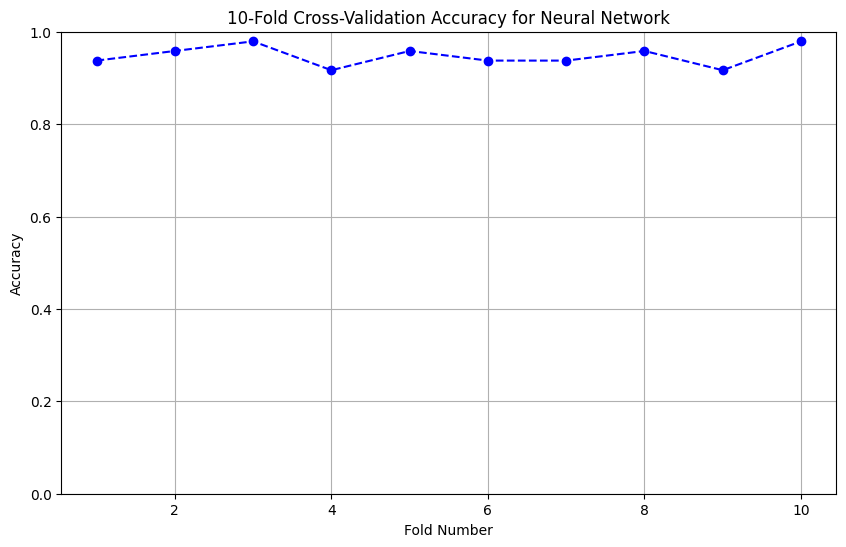

In [74]:
# Plot 10-fold cross-validation scores for the neural network
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), cross_val_scores_keras, marker='o', linestyle='--', color='b')
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.title('10-Fold Cross-Validation Accuracy for Neural Network')
plt.ylim(0.0, 1.0)  # Adjust the y-axis limits based on your accuracy range
plt.grid()
plt.show()

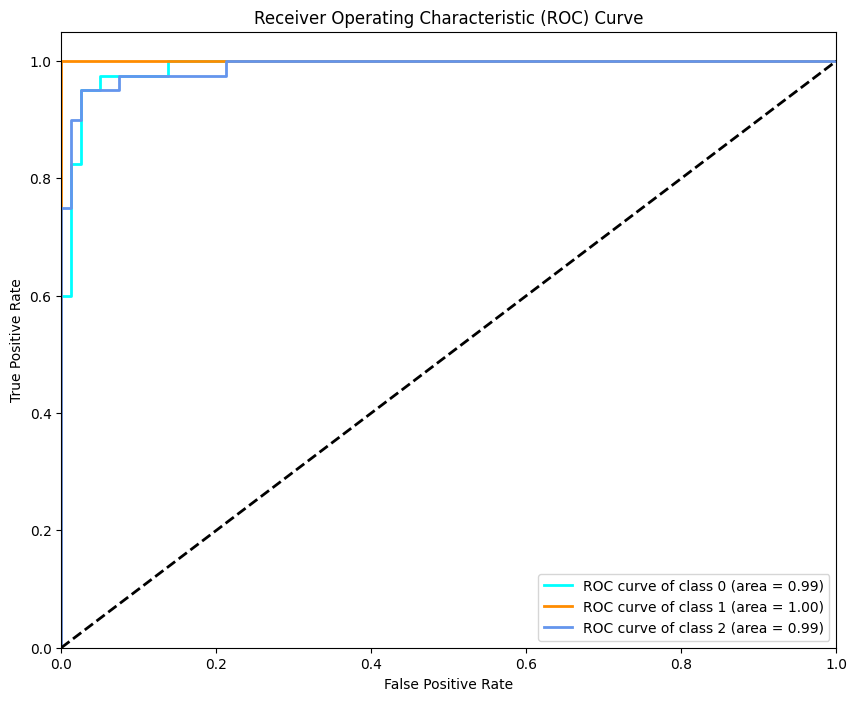

In [78]:
# ROC curve for the neural network model
fpr = {}
tpr = {}
roc_auc = {}

unique_classes = np.unique(y_test_labels)

for i in unique_classes:
    fpr[i], tpr[i], _ = roc_curve(y_test_labels == i, y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = ['aqua', 'darkorange', 'cornflowerblue']
for i, color in zip(unique_classes, colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Deep Learning Architecture - 2

In [79]:
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc

In [81]:
# Define the neural network model with dropout layers
model = Sequential([
    Dense(1024, activation='relu', input_shape=(X_train_pca.shape[1],)),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')
])

In [82]:
# Compile the model with Adam optimizer
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [83]:
# Train the model
history = model.fit(X_train_pca, y_train_1, validation_data=(X_test_pca, y_test_1), epochs=20, batch_size=32)

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.4084 - loss: 1.4771 - val_accuracy: 0.7083 - val_loss: 0.5484
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6747 - loss: 0.7313 - val_accuracy: 0.9250 - val_loss: 0.2650
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7725 - loss: 0.4552 - val_accuracy: 0.9500 - val_loss: 0.1892
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8861 - loss: 0.2771 - val_accuracy: 0.9583 - val_loss: 0.1751
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9053 - loss: 0.2579 - val_accuracy: 0.9667 - val_loss: 0.1696
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9235 - loss: 0.2182 - val_accuracy: 0.9417 - val_loss: 0.1681
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9305 - loss: 0.2215 - val_accuracy: 0.9500 - val_loss: 0.1491
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9533 - loss: 0.1222 - val_accuracy: 0.9500 - va

In [85]:
# Make predictions
y_pred_prob = model.predict(X_test_pca)
y_pred = y_pred_prob.argmax(axis=-1)
y_test_labels = y_test_1.argmax(axis=-1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [86]:
print("Sample predictions:", y_pred[:10])
print("Sample true labels:", y_test_labels[:10])

Sample predictions: [0 0 1 2 1 1 1 1 2 0]
Sample true labels: [0 0 1 2 1 1 1 1 2 0]


In [87]:
# Plot training and validation accuracy and loss
epochs = range(1, len(history.history['accuracy']) + 1)

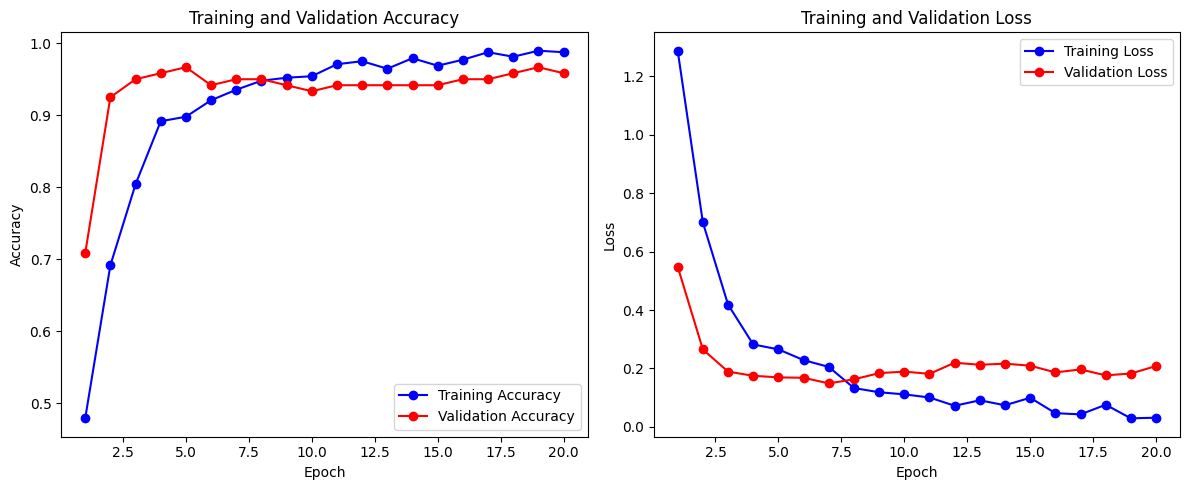

In [88]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], 'bo-', label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], 'bo-', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Confusion Matrix:
[[38  0  2]
 [ 0 40  0]
 [ 3  0 37]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94        40
           1       1.00      1.00      1.00        40
           2       0.95      0.93      0.94        40

    accuracy                           0.96       120
   macro avg       0.96      0.96      0.96       120
weighted avg       0.96      0.96      0.96       120



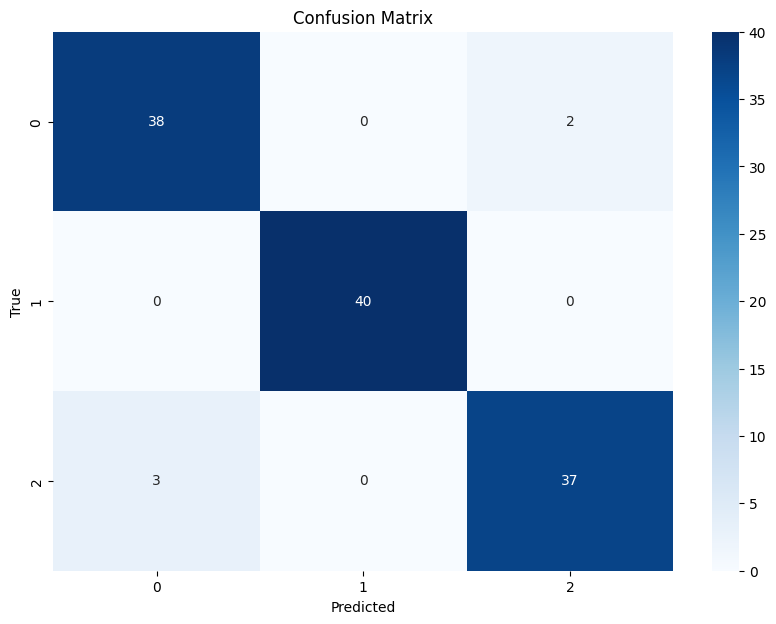

In [90]:
# Confusion matrix and classification report
conf_matrix = confusion_matrix(y_test_labels, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

class_report = classification_report(y_test_labels, y_pred)
print("Classification Report:")
print(class_report)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(3), yticklabels=range(3))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [91]:
# 10-fold cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [94]:
def cross_val_keras_model(model, X, y, cv):
    val_scores = []
    for train_idx, val_idx in cv.split(X, y):
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]

        model_fold = Sequential([
            Dense(1024, activation='relu', input_shape=(X.shape[1],)),
            Dropout(0.5),
            Dense(512, activation='relu'),
            Dropout(0.5),
            Dense(256, activation='relu'),
            Dropout(0.5),
            Dense(128, activation='relu'),
            Dropout(0.5),
            Dense(6, activation='softmax')
        ])

        optimizer = Adam(learning_rate=0.001)
        model_fold.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

        y_train_fold_cat = to_categorical(y_train_fold, num_classes=6)
        y_val_fold_cat = to_categorical(y_val_fold, num_classes=6)

        model_fold.fit(X_train_fold, y_train_fold_cat, epochs=20, batch_size=32, verbose=0)
        val_loss, val_accuracy = model_fold.evaluate(X_val_fold, y_val_fold_cat, verbose=0)
        val_scores.append(val_accuracy)

    return val_scores

In [95]:
cross_val_scores_keras = cross_val_keras_model(model, X_train_pca, y_train, cv)

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [96]:
print(f"Cross-Validation Scores: {cross_val_scores_keras}")
print(f"Mean Cross-Validation Score: {np.mean(cross_val_scores_keras)}")

Cross-Validation Scores: [0.9375, 0.9583333134651184, 0.9791666865348816, 0.9166666865348816, 0.9583333134651184, 0.9583333134651184, 0.9791666865348816, 0.9375, 0.875, 1.0]
Mean Cross-Validation Score: 0.95


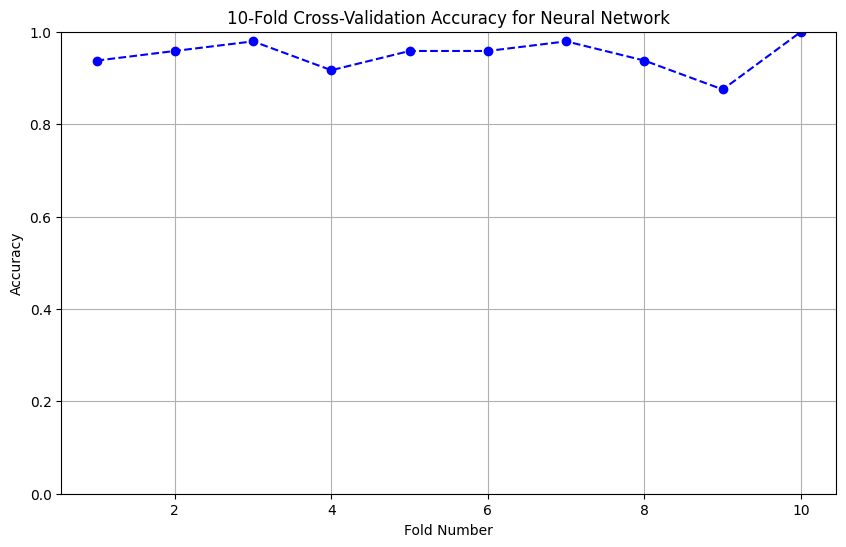

In [97]:
# Plot 10-fold cross-validation scores for the neural network
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), cross_val_scores_keras, marker='o', linestyle='--', color='b')
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.title('10-Fold Cross-Validation Accuracy for Neural Network')
plt.ylim(0.0, 1.0)  # Adjust the y-axis limits based on your accuracy range
plt.grid()
plt.show()

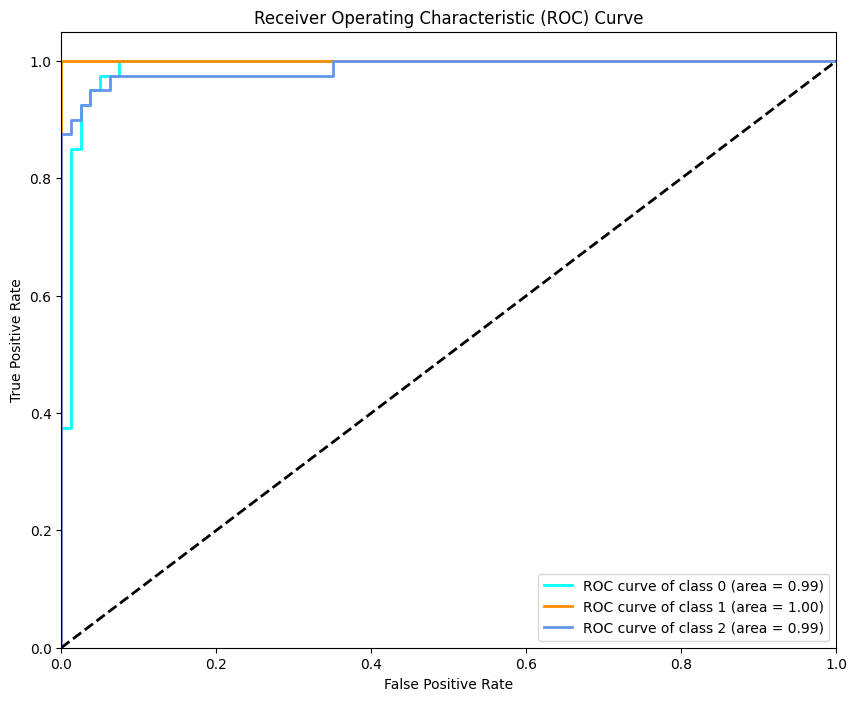

In [98]:
# ROC curve for the neural network model
fpr = {}
tpr = {}
roc_auc = {}

unique_classes = np.unique(y_test_labels)

for i in unique_classes:
    fpr[i], tpr[i], _ = roc_curve(y_test_labels == i, y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple']
for i, color in zip(unique_classes, colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Logostic Regression

In [99]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc

In [100]:
# Define and fit the Logistic Regression model
logistic_regression = LogisticRegression(random_state=42)
logistic_regression.fit(X_train_pca, y_train)

LogisticRegression(random_state=42)

In [101]:
# Perform 10-Fold Cross-Validation
cv_scores = cross_val_score(logistic_regression, X_train_pca, y_train, cv=10, scoring='accuracy')
print("10-Fold Cross-Validation Accuracy Scores:", cv_scores)
print("Mean Accuracy Score from 10-Fold Cross-Validation:", cv_scores.mean())

10-Fold Cross-Validation Accuracy Scores: [0.91666667 0.875      0.9375     1.         0.97916667 0.875
 0.95833333 0.91666667 0.95833333 0.91666667]
Mean Accuracy Score from 10-Fold Cross-Validation: 0.9333333333333332


In [102]:
# Predict probabilities for ROC curve
y_pred_prob_lr = logistic_regression.predict_proba(X_test_pca)[:, 1]

In [103]:
# Fit and evaluate using Grid Search with Cross-Validation
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear', 'saga'],
}

In [104]:
import warnings
warnings.filterwarnings("ignore")

logistic_regression_gv = LogisticRegression(random_state=42)

grid_search_lr = GridSearchCV(logistic_regression_gv, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_lr.fit(X_train_pca, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['lbfgs', 'liblinear', 'saga']},
             scoring='accuracy')

In [105]:
best_params = grid_search_lr.best_params_
best_estimator = grid_search_lr.best_estimator_

print("Best parameters found: ", best_params)
print("Best estimator found: ", best_estimator)

Best parameters found:  {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Best estimator found:  LogisticRegression(C=0.01, random_state=42)


In [106]:
y_pred_lr = grid_search_lr.predict(X_test_pca)

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.93      0.90        40
           1       1.00      1.00      1.00        40
           2       0.92      0.88      0.90        40

    accuracy                           0.93       120
   macro avg       0.93      0.93      0.93       120
weighted avg       0.93      0.93      0.93       120

Logistic Regression Confusion Matrix:
[[37  0  3]
 [ 0 40  0]
 [ 5  0 35]]


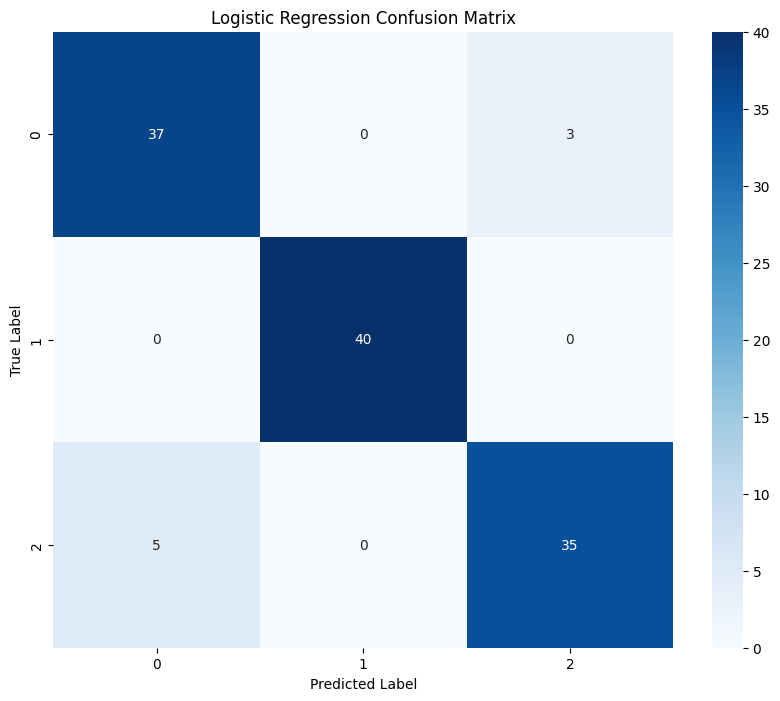

In [107]:
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

print("Logistic Regression Confusion Matrix:")
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)
print(conf_matrix_lr)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

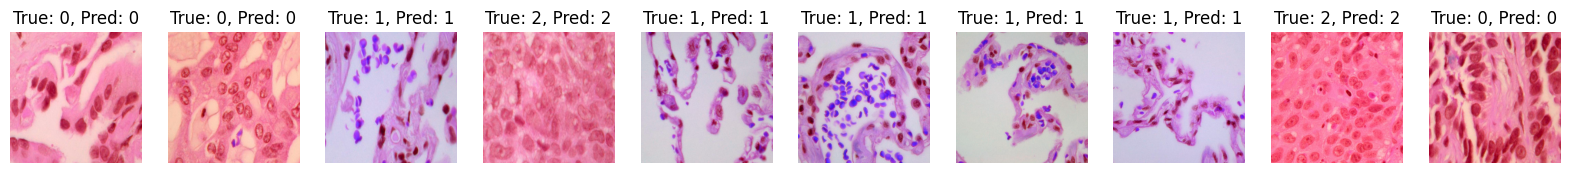

In [108]:
num_samples = 10
fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))

for i in range(num_samples):
    ax = axes[i]
    ax.imshow(X_test[i])
    ax.axis('off')
    ax.set_title(f"True: {y_test[i]}, Pred: {y_pred_lr[i]}")

plt.show()

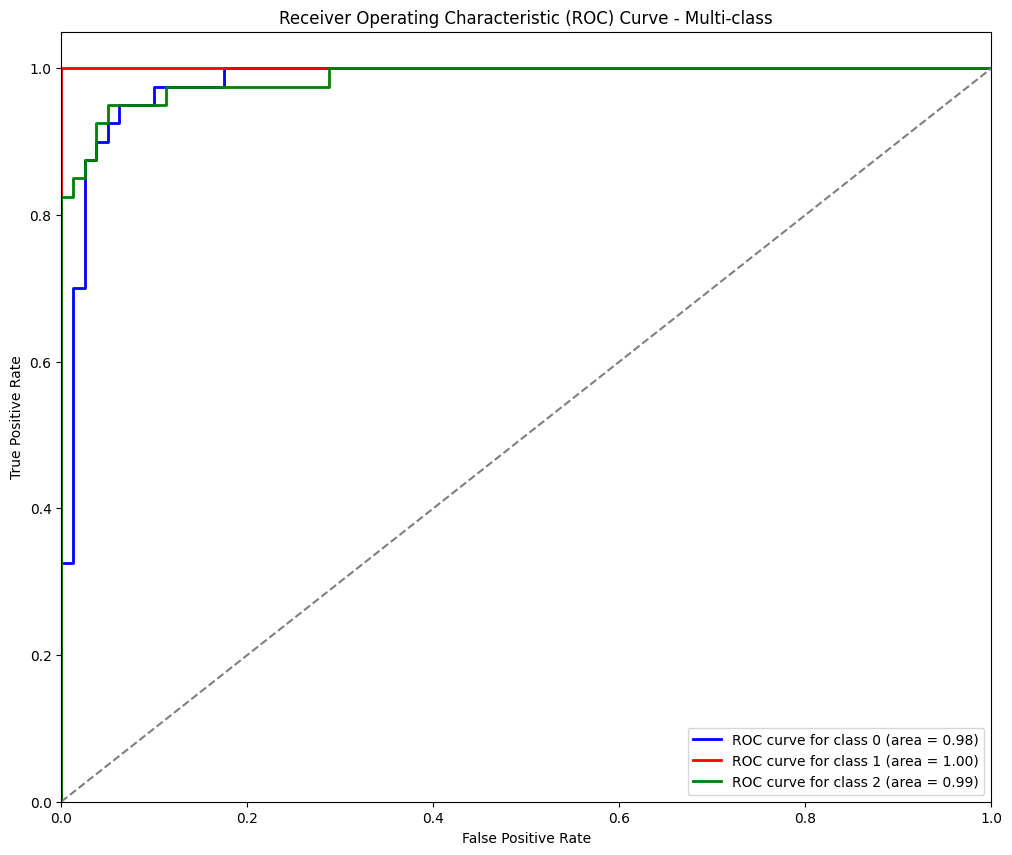

In [110]:
import matplotlib.pyplot as plt

# Binarize the output labels
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_binarized.shape[1]

# Predict probabilities
y_pred_prob_lr = grid_search_lr.predict_proba(X_test_pca)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_prob_lr[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(12, 10))

colors = ['blue', 'red', 'green']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'ROC curve for class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Multi-class')
plt.legend(loc="lower right")
plt.show()

Random Forest Classifier

In [111]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [112]:
# Define and fit the Random Forest model
random_forest = RandomForestClassifier(n_estimators=300, random_state=42)
random_forest.fit(X_train_pca, y_train)

RandomForestClassifier(n_estimators=300, random_state=42)

In [113]:
# Perform 10-Fold Cross-Validation
cv_scores = cross_val_score(random_forest, X_train_pca, y_train, cv=10, scoring='accuracy')
print("10-Fold Cross-Validation Accuracy Scores:", cv_scores)
print("Mean Accuracy Score from 10-Fold Cross-Validation:", cv_scores.mean())

10-Fold Cross-Validation Accuracy Scores: [0.89583333 0.91666667 0.9375     0.9375     0.97916667 0.89583333
 0.9375     0.91666667 0.89583333 0.89583333]
Mean Accuracy Score from 10-Fold Cross-Validation: 0.9208333333333334


In [114]:
# Predict probabilities for ROC curve
y_pred_rf_prob = random_forest.predict_proba(X_test_pca)

In [115]:
# Fit and evaluate using Grid Search with Cross-Validation
param_grid = {
    'n_estimators': [100, 200, 300],  
    'max_depth': [None, 10, 20, 30],  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4]  
}

In [116]:
grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

In [117]:
grid_search_rf.fit(X_train_pca, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [118]:
best_model = grid_search_rf.best_estimator_

In [119]:
y_pred_rf = best_model.predict(X_test_pca)

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.93      0.89        40
           1       1.00      0.95      0.97        40
           2       0.92      0.90      0.91        40

    accuracy                           0.93       120
   macro avg       0.93      0.92      0.93       120
weighted avg       0.93      0.93      0.93       120

Random Forest Confusion Matrix:
[[37  0  3]
 [ 2 38  0]
 [ 4  0 36]]


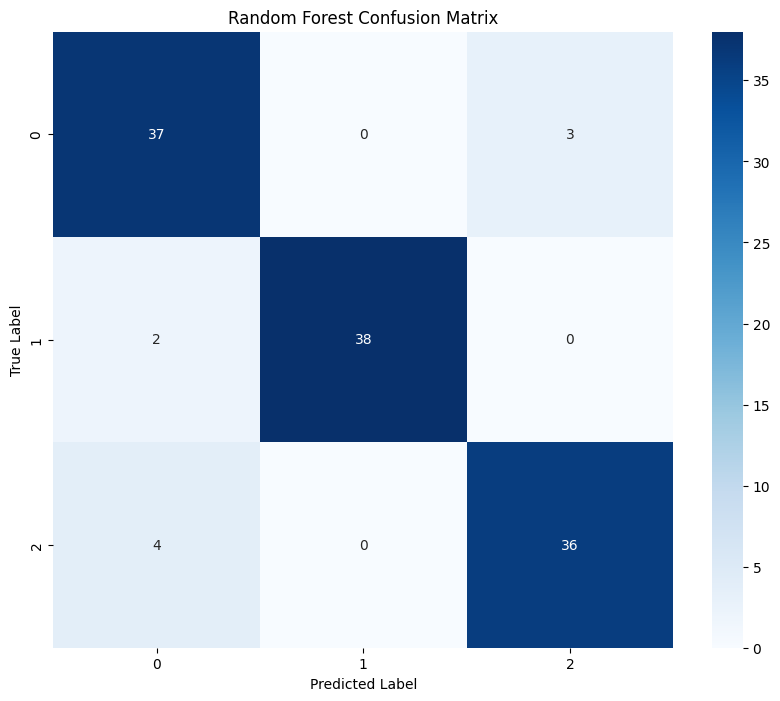

In [120]:
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

print("Random Forest Confusion Matrix:")
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print(conf_matrix_rf)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Random Forest Confusion Matrix')
plt.show()

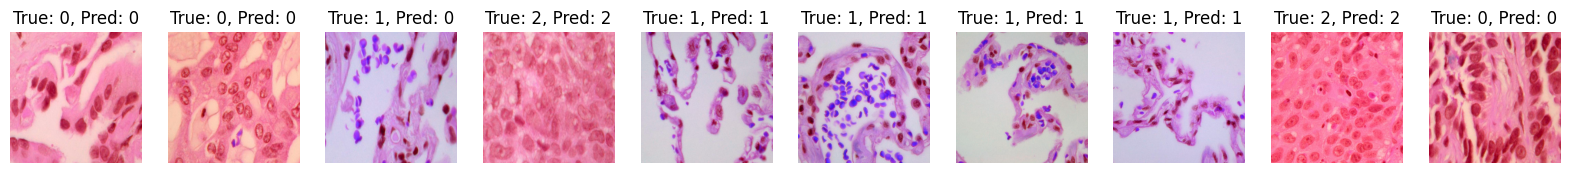

In [121]:
num_samples = 10
fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))

for i in range(num_samples):
    ax = axes[i]
    ax.imshow(X_test[i])
    ax.axis('off')
    ax.set_title(f"True: {y_test[i]}, Pred: {y_pred_rf[i]}")

plt.show()

In [122]:
# Binarize the output labels
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_binarized.shape[1]

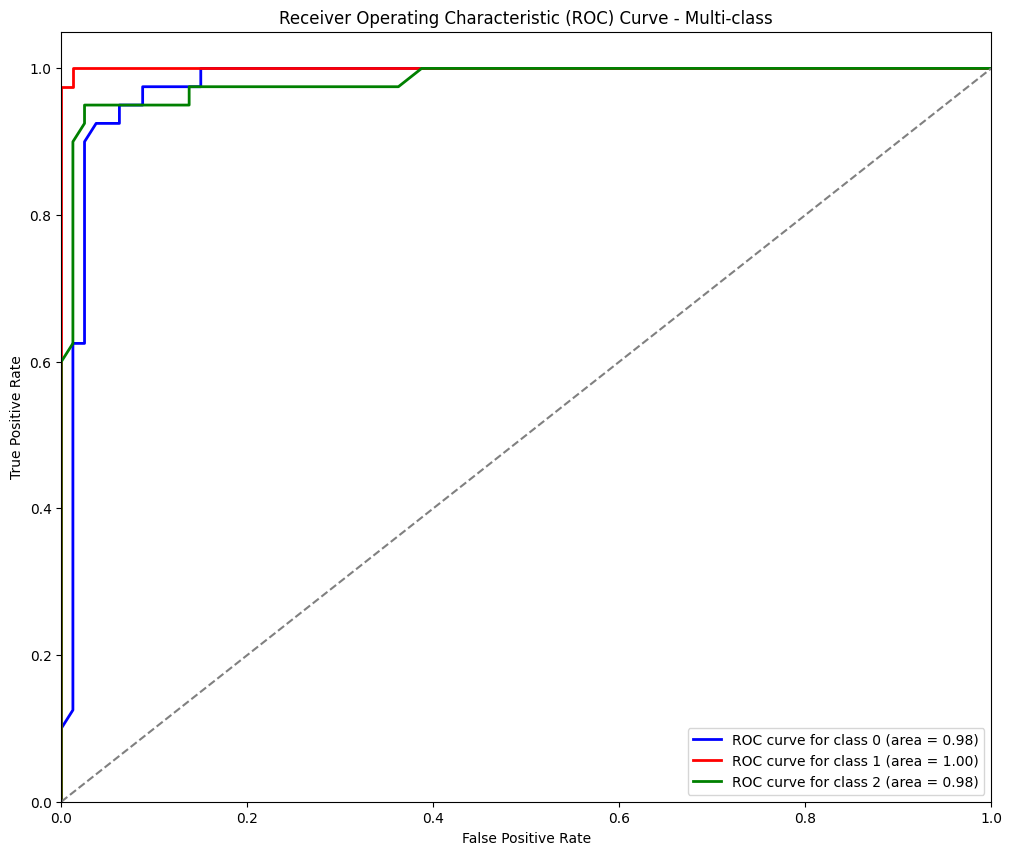

In [123]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_rf_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(12, 10))

colors = ['blue', 'red', 'green', 'darkorange', 'purple', 'pink']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'ROC curve for class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Multi-class')
plt.legend(loc="lower right")
plt.show()

Decision Tree

In [124]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [125]:
# Define and fit the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_pca, y_train)

DecisionTreeClassifier(random_state=42)

In [126]:
# Perform 10-Fold Cross-Validation
cv_scores = cross_val_score(dt_model, X_train_pca, y_train, cv=10, scoring='accuracy')
print("10-Fold Cross-Validation Accuracy Scores:", cv_scores)
print("Mean Accuracy Score from 10-Fold Cross-Validation:", cv_scores.mean())

10-Fold Cross-Validation Accuracy Scores: [0.79166667 0.77083333 0.85416667 0.79166667 0.72916667 0.8125
 0.83333333 0.85416667 0.85416667 0.75      ]
Mean Accuracy Score from 10-Fold Cross-Validation: 0.8041666666666668


In [127]:
# Predict probabilities for ROC curve
y_pred_dt_prob = dt_model.predict_proba(X_test_pca)

In [128]:
# Fit and evaluate using Grid Search with Cross-Validation
param_grid = {
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [129]:
grid_search_dt = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

grid_search_dt.fit(X_train_pca, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             verbose=2)

In [130]:
best_model = grid_search_dt.best_estimator_

y_pred_dt = best_model.predict(X_test_pca)

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.82      0.81        40
           1       0.95      0.88      0.91        40
           2       0.88      0.93      0.90        40

    accuracy                           0.88       120
   macro avg       0.88      0.88      0.88       120
weighted avg       0.88      0.88      0.88       120

Decision Tree Confusion Matrix:
[[33  2  5]
 [ 5 35  0]
 [ 3  0 37]]


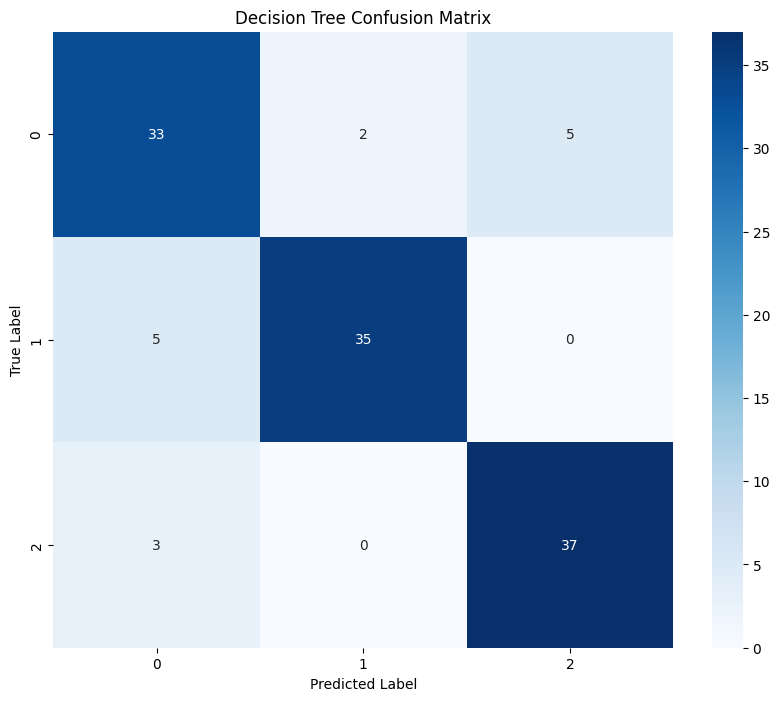

In [131]:
print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt))

print("Decision Tree Confusion Matrix:")
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
print(conf_matrix_dt)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_dt, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Decision Tree Confusion Matrix')
plt.show()

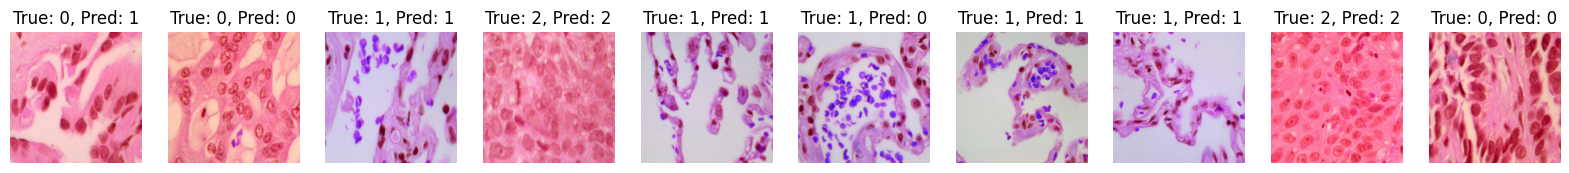

In [132]:
num_samples = 10
fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))

for i in range(num_samples):
    ax = axes[i]
    ax.imshow(X_test[i])
    ax.axis('off')
    ax.set_title(f"True: {y_test[i]}, Pred: {y_pred_dt[i]}")

plt.show()

In [133]:
# Binarize the output labels
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_binarized.shape[1]

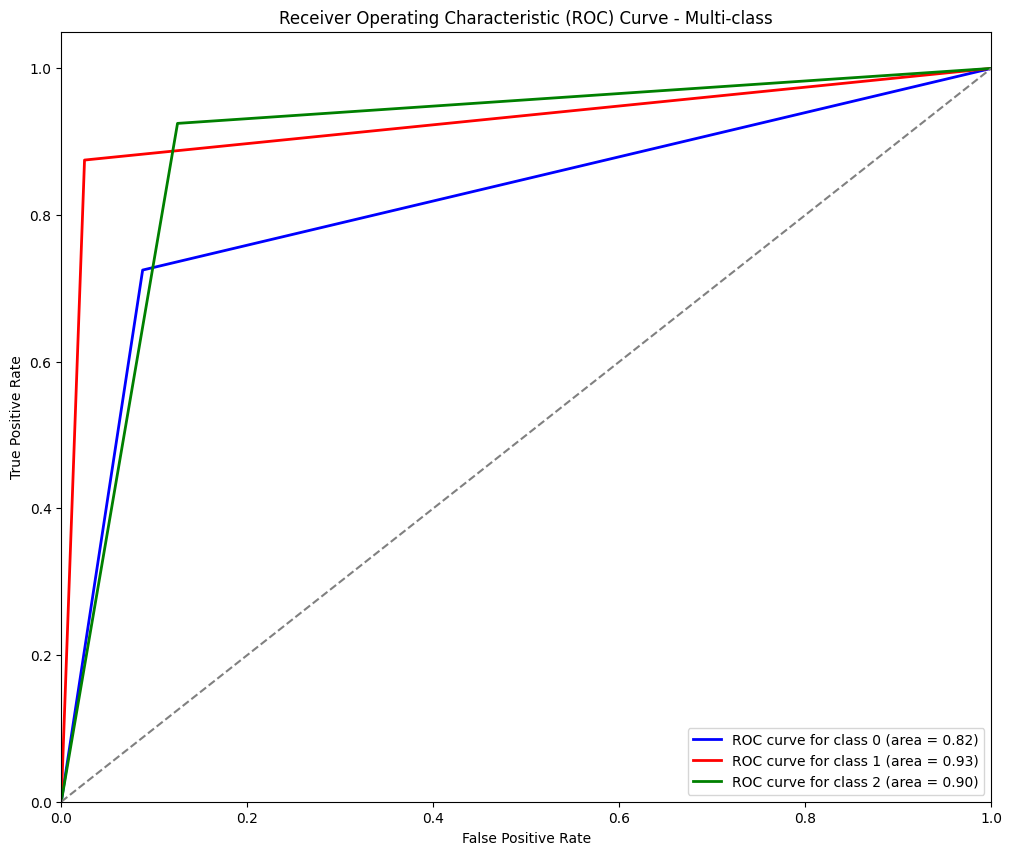

In [134]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_dt_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(12, 10))

colors = ['blue', 'red', 'green', 'darkorange', 'purple', 'pink']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'ROC curve for class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Multi-class')
plt.legend(loc="lower right")
plt.show()

Xgoobst

In [135]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [136]:
# Define and fit the XGBoost model
xgb_model = xgb.XGBClassifier(n_estimators=300, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train_pca, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [137]:
# Perform 10-Fold Cross-Validation
cv_scores = cross_val_score(xgb_model, X_train_pca, y_train, cv=10, scoring='accuracy')
print("10-Fold Cross-Validation Accuracy Scores:", cv_scores)
print("Mean Accuracy Score from 10-Fold Cross-Validation:", cv_scores.mean())

10-Fold Cross-Validation Accuracy Scores: [0.9375     0.9375     0.9375     0.9375     0.95833333 0.89583333
 0.95833333 0.89583333 0.875      0.9375    ]
Mean Accuracy Score from 10-Fold Cross-Validation: 0.9270833333333334


In [138]:
# Predict probabilities for ROC curve
y_pred_xgb_prob = xgb_model.predict_proba(X_test_pca)

In [139]:
# Grid Search with Cross-Validation
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
}

In [140]:
grid_search_xgb = GridSearchCV(estimator=xgb.XGBClassifier(random_state=42, use_label_encoder=False), param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search_xgb.fit(X_train_pca, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [141]:
best_model = grid_search_xgb.best_estimator_

y_pred_xgb = best_model.predict(X_test_pca)

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.93      0.90        40
           1       1.00      0.97      0.99        40
           2       0.92      0.90      0.91        40

    accuracy                           0.93       120
   macro avg       0.93      0.93      0.93       120
weighted avg       0.93      0.93      0.93       120

XGBoost Confusion Matrix:
[[37  0  3]
 [ 1 39  0]
 [ 4  0 36]]


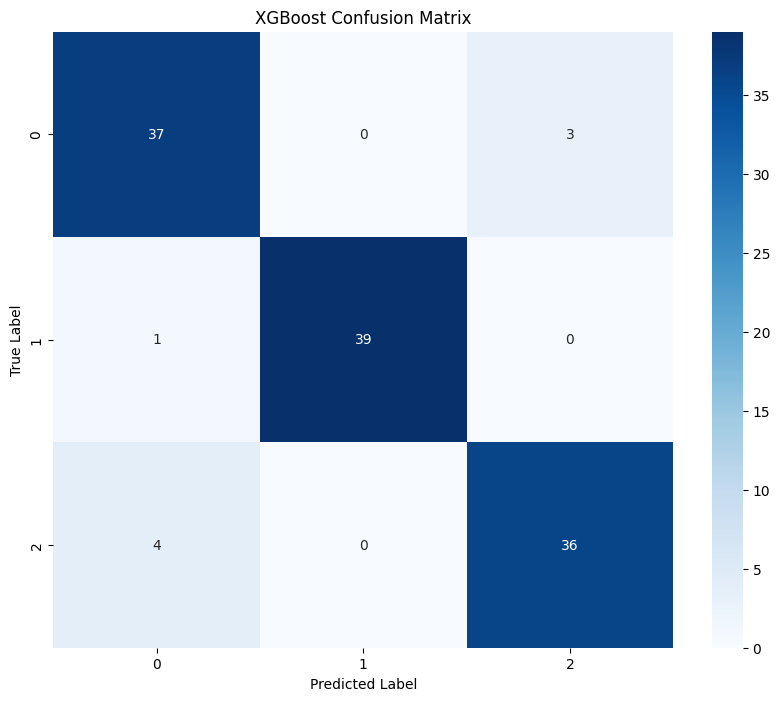

In [142]:
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

print("XGBoost Confusion Matrix:")
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
print(conf_matrix_xgb)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('XGBoost Confusion Matrix')
plt.show()

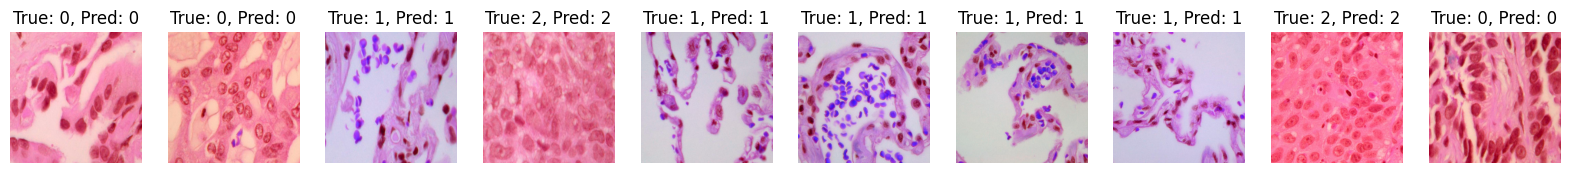

In [143]:
num_samples = 10
fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))

for i in range(num_samples):
    ax = axes[i]
    ax.imshow(X_test[i])
    ax.axis('off')
    ax.set_title(f"True: {y_test[i]}, Pred: {y_pred_xgb[i]}")

plt.show()

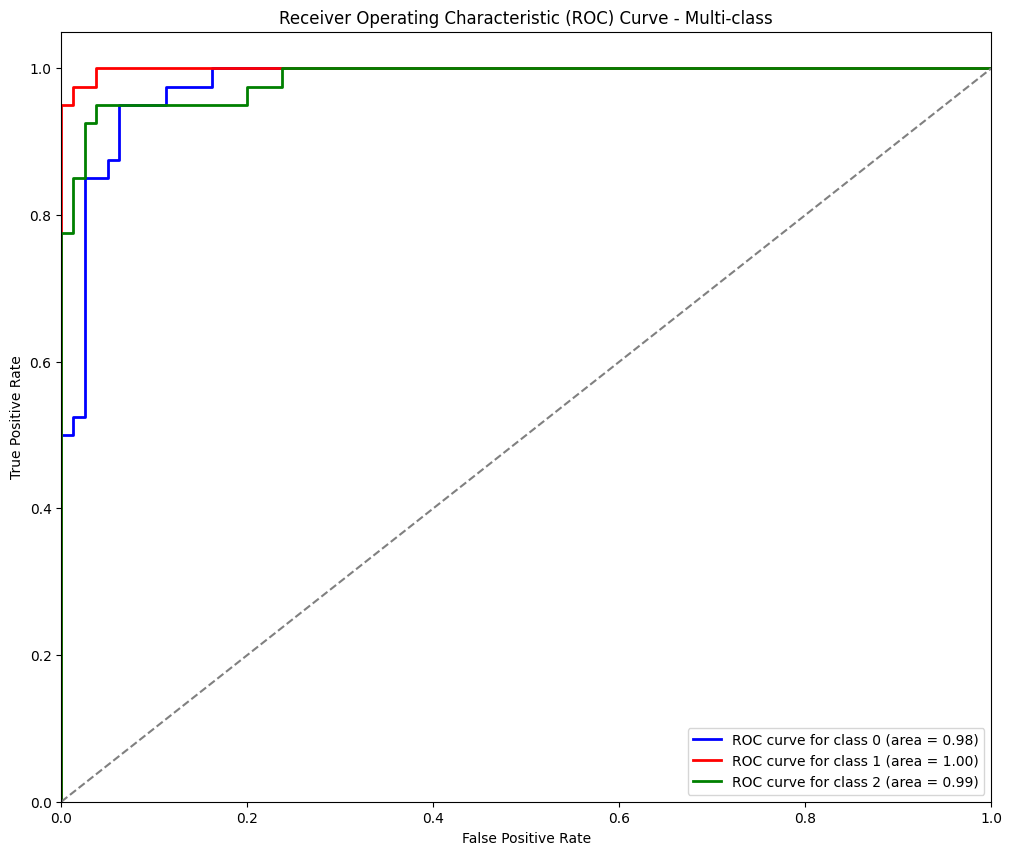

In [144]:
# Binarize the output labels
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_xgb_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(12, 10))

colors = ['blue', 'red', 'green', 'darkorange', 'purple', 'pink']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'ROC curve for class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Multi-class')
plt.legend(loc="lower right")
plt.show()